# Chapter 16: Contextual Word Embeddings with Transformers

In [2]:
!pip install transformers evaluate sentence-transformers datasets

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/educational_transformer.py

In [18]:
from educational_transformer import PositionalEncoding, EncoderLayer, EncoderTransf

## 16.3 Attention Is All You Need

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/translation_att.png)

## 16.4 Transformer

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/stacked_layers.png)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/full_transformer.png)

## 16.5 An Encoder-Based Model for Classification

### 16.5.1 AG News Dataset

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step1.png)

In [6]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step2.png)

In [1]:
import numpy as np

chr_codes = np.array([
     36,   151,    38,  8220,   147,   148,   146,   225,   133,    39,  8221,  8212,   232,   149,   145,   233,
  64257,  8217,   163,   160,    91,    93,  8211,  8482,   234,    37,  8364,   153,   195,   169
])
chr_subst = {f' #{c};':chr(c) for c in chr_codes}
chr_subst.update({' amp;': '&', ' quot;': "'", ' hellip;': '...', ' nbsp;': ' ', '&lt;': '', '&gt;': '',
                  '&lt;em&gt;': '', '&lt;/em&gt;': '', '&lt;strong&gt;': '', '&lt;/strong&gt;': ''})

In [2]:
def replace_chars(sent):
    to_replace = [c for c in list(chr_subst.keys()) if c in sent]
    for c in to_replace:
        sent = sent.replace(c, chr_subst[c])
    return sent

def preproc_description(desc):
    desc = desc.replace('\\', ' ').strip()
    return replace_chars(desc)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In [3]:
from datasets import load_dataset, Split, DatasetDict

colnames = ['topic', 'title', 'news']

train_ds = load_dataset("csv", data_files='train.csv', sep=',', split=Split.ALL, column_names=colnames)
test_ds = load_dataset("csv", data_files='test.csv', sep=',', split=Split.ALL, column_names=colnames)

datasets = DatasetDict({'train': train_ds, 'test': test_ds})
datasets = datasets.map(lambda row: {'topic': row['topic']-1, 'news': preproc_description(row['news'])})
datasets = datasets.select_columns(['topic', 'news'])

Found cached dataset csv (/home/dvgodoy/.cache/huggingface/datasets/csv/default-74551251eaf25b66/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/dvgodoy/.cache/huggingface/datasets/csv/default-cc3721dbf091fd55/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [5]:
from torch.utils.data import DataLoader

dataloaders = {}
dataloaders['train'] = DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datasets['test'], batch_size=32)

### 16.5.2 Tokenizing and Padding

In [6]:
from gensim import downloader
from gensim.utils import simple_preprocess

vector = downloader.load('glove-wiki-gigaword-50')

tokenizer = simple_preprocess
d_model = vector.vector_size
max_length = 100
n_outputs = 4

key_to_index = vector.key_to_index
pad_token_id = len(key_to_index)
unk_token_id = pad_token_id + 1

In [7]:
def encode_str(key_to_index, tokens, unk_token_id):
    token_ids = [key_to_index.get(token, unk_token_id) for token in tokens]
    return token_ids

def encode_batch(key_to_index, batch, max_len=None, padding=False, pad_token_id=-1, unk_token_id=-1):
    # Truncate every sentence to max_len
    # write your code here
    if isinstance(max_len, int):
        truncated = [s[:max_len] for s in batch]
    else:
        truncated = batch[:]

    # Check the actual maximum length of the (truncated) inputs
    # write your code here
    current_max = max([len(s) for s in truncated])
    
    batch_ids = []
    for tokens in truncated:
        token_ids = encode_str(key_to_index, tokens, unk_token_id)
        if padding:
            # Appends as many padding tokens as necessary to make every
            # sentence as long as the actual maximum length
            # write your code here            
            token_ids.extend([pad_token_id] * (current_max - len(token_ids)))
        batch_ids.append(token_ids)
    return batch_ids

In [8]:
batch = next(iter(dataloaders['train']))

labels, sentences = batch['topic'], batch['news']

tokenized_X = [tokenizer(d) for d in sentences]

padded_X = encode_batch(key_to_index, 
                        tokenized_X, 
                        max_len=max_length-1, 
                        padding=True, 
                        pad_token_id=pad_token_id, 
                        unk_token_id=unk_token_id)
print(padded_X[:3])

[[0, 444, 6725, 13068, 10, 0, 146, 863, 515, 31, 848, 5, 0, 55, 8232, 13, 534, 43, 7053, 75, 29, 4383, 3641, 1370, 325, 1646, 37, 1175, 4167, 16, 184, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000], [4790, 14882, 87, 307, 4907, 321, 0, 614, 2769, 11017, 4, 320, 74, 0, 614, 1518, 2897, 6, 121, 292, 282, 277, 504, 2696, 432, 2426, 25, 4201, 1947, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000], [83, 81, 1765, 5259, 3, 2709, 288, 3552, 400001, 5, 974, 20113, 11495, 210, 81, 3316, 33, 4, 88, 12, 5717, 19, 3, 450, 58, 11495, 210, 20, 43, 511, 47, 527, 13, 288, 3552, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,

In [9]:
import torch

# If a BoolTensor is provided, positions with True is not allowed to attend while False values will be unchanged.
# https://pytorch.org/tutorials/beginner/translation_transformer.html
# src_padding_mask = (src == PAD_IDX).transpose(0, 1)

pad_mask = torch.as_tensor(padded_X) == pad_token_id
pad_mask.shape, pad_mask[0]

(torch.Size([32, 59]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]))

### 16.5.3 Word Embeddings

In [10]:
import torch.nn as nn

tensor_glove = torch.as_tensor(vector.vectors).float()
# zero embeddings for padding and unknown tokens
tensor_glove = torch.cat([tensor_glove, torch.zeros((2, d_model))])

embedding = nn.Embedding.from_pretrained(tensor_glove)

def get_embeddings(embedding, token_ids):
    valid_ids = torch.as_tensor([token_id for token_id in token_ids if token_id >= 0])
    embedded_tokens = embedding(valid_ids)
    return embedded_tokens

def get_batch_embeddings(embedding, token_ids):
    # Retrieve embeddings from the Vector object using `get_vecs_by_tokens`
    # Make sure to get the shapes right, and concatenate the tensors so
    # the resulting shape is N, L, D
    embeddings = torch.cat([get_embeddings(embedding, ids).unsqueeze(0)
                            for ids in token_ids], dim=0)
    return embeddings

In [11]:
src = get_batch_embeddings(embedding, padded_X)
src.shape, src[:2]

(torch.Size([32, 59, 50]),
 tensor([[[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
          [ 0.6643,  0.7181,  0.1751,  ..., -0.3244,  0.4245, -0.7097],
          [ 0.8685,  0.7152,  1.1435,  ..., -0.3224,  0.3853, -0.2879],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.9450,  0.7095,  0.4264,  ..., -0.7326, -1.1373,  1.4974],
          [-1.0609,  0.7915,  0.5971,  ...,  0.3167, -0.9157,  0.7568],
          [ 0.4054,  0.4381,  0.3624,  ..., -0.1566, -0.3029, -0.7754],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]))

### 16.5.4 Classifier Token

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [12]:
import torch.nn as nn

cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
# Special classifier token
# 1, 1, D -> N, 1, D
cls_tokens = cls_token.expand(len(padded_X), -1, -1)
cls_tokens.shape, cls_tokens

(torch.Size([32, 1, 50]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ExpandBackward0>))

In [13]:
# Concatenates CLS tokens -> N, 1 + L, D
embeddings = torch.cat((cls_tokens, src), dim=1)
embeddings.shape, embeddings[:2]

(torch.Size([32, 60, 50]),
 tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
          [ 0.6643,  0.7181,  0.1751,  ..., -0.3244,  0.4245, -0.7097],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.9450,  0.7095,  0.4264,  ..., -0.7326, -1.1373,  1.4974],
          [-1.0609,  0.7915,  0.5971,  ...,  0.3167, -0.9157,  0.7568],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<SliceBackward0>))

In [14]:
cls_mask = torch.zeros(len(padded_X), 1)
pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
pad_mask.shape, pad_mask[0]

(torch.Size([32, 60]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]))

### 16.5.5 Positioning

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [19]:
pe = PositionalEncoding(max_length, d_model)
pe.pe.shape

torch.Size([1, 100, 50])

In [20]:
embeddings = pe(embeddings)
embeddings[1].shape, embeddings[1]

(torch.Size([60, 50]),
 tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [-5.8408e+00,  5.5572e+00,  3.6531e+00,  ..., -4.1803e+00,
          -8.0418e+00,  1.1588e+01],
         [-6.5924e+00,  5.1805e+00,  5.2043e+00,  ...,  3.2391e+00,
          -6.4749e+00,  6.3514e+00],
         ...,
         [ 4.3616e-01,  8.9987e-01,  9.8651e-01,  ...,  9.9993e-01,
           8.2389e-03,  9.9997e-01],
         [ 9.9287e-01,  1.1918e-01,  6.5525e-01,  ...,  9.9993e-01,
           8.3835e-03,  9.9996e-01],
         [ 6.3674e-01, -7.7108e-01,  2.2679e-02,  ...,  9.9992e-01,
           8.5280e-03,  9.9996e-01]], grad_fn=<SelectBackward0>))

### 16.5.6 Hidden States

In [21]:
layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)

In [22]:
hidden_states = encoder(embeddings, pad_mask)
hidden_states.shape

torch.Size([32, 60, 50])

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/cls_hidden_state.png)

### 16.5.7 Classifier "Head"

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [23]:
# Gets state from first token only: [CLS]
cls_state = hidden_states[:, 0, :]  # N, D
cls_state.shape

torch.Size([32, 50])

In [24]:
mlp = nn.Linear(d_model, n_outputs)

logits = mlp(cls_state) # N, outputs
logits.shape

torch.Size([32, 4])

In [25]:
class TransfClassifier(nn.Module):
    def __init__(self, tokenizer, vector, encoder, n_outputs):
        super().__init__()
        # Our "hybrid" transformer takes an instance of the
        # Vector class, such as GloVe to retrieve the word
        # embeddings
        self.vector = vector
        # The number of dimensions (D) of the model is the
        # same as the size of the embeddings
        
        self.d_model = vector.vector_size

        tensor_glove = torch.as_tensor(vector.vectors).float()
        tensor_glove = torch.cat([tensor_glove, torch.zeros((2, self.d_model))])
        self.fixed_embeddings = nn.Embedding.from_pretrained(tensor_glove)
        self.pad_token_id = len(self.vector.key_to_index)
        self.unk_token_id = self.pad_token_id + 1
        
        # The tokenizer that will be used - it needs to
        # produce tokens that are understood by the Vector
        # GloVe's vocabulary is made of full words (not subwords)
        # so the tokenizer must produce full words as well
        self.tokenizer = tokenizer
        # The number of outputs/classes the model should
        # produce logits for
        self.n_outputs = n_outputs
        
        # The underlying structure of the model is
        # made of a Transformer Encoder
        self.encoder = encoder
        # The MLP is the classifier "head" that maps
        # the hidden state produced by the classifier token
        # to the number of outputs (logits)
        self.mlp = nn.Linear(self.d_model, n_outputs)
        # These are the embeddings corresponding to the
        # special classifier token, which are going to
        # be learned during training - they are a parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))
        
        # Positional encoding will add positional information
        # according to the maximum sequence length, and number
        # of dimenions of the embeddings
        self.pe = PositionalEncoding(self.encoder.pe.max_len, self.d_model)
        
    def _get_batch_embeddings(self, token_ids):
        device = next(iter(self.parameters())).device
        # Retrieve embeddings from the Vector object using `get_vecs_by_tokens`
        # Make sure to get the shapes right, and concatenate the tensors so
        # the resulting shape is N, L, D
        embeddings = torch.cat([self.fixed_embeddings(torch.as_tensor(ids, device=device)).unsqueeze(0)
                                for ids in token_ids], dim=0)
        return embeddings
    
    def preprocess(self, X):
        # in a mini-batch of N sequences
        # gets embeddings (size D) for each token
        # in the sequence (size L)
        # N, L -> N, L, D
        src = self._get_batch_embeddings(X)
        
        # creates a mini-batch (size N) of special classifier tokens
        # each token has same size as embeddings (D)
        # 1, 1, D -> N, 1, D
        # it's part of the model (created as nn.Parameter), so it is sent to the device
        # with the rest of the model
        cls_tokens = self.cls_token.expand(len(X), -1, -1)  
        
        # Concatenates CLS tokens to the source embeddings 
        # N, 1 + L, D
        src = torch.cat((cls_tokens, src.to(cls_tokens.device)), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        # src to L, N, D and output states back to N, L, D
        states = self.encoder(source, source_mask)
        return states

    def source_mask(self, X):
        # If a BoolTensor is provided, positions with True is not allowed to attend
        # while False values will be unchanged.
        
        # Original code
        # https://pytorch.org/tutorials/beginner/translation_transformer.html
        # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        
        # the classifier token shouldn't be ignored, so its mask is zero/False
        cls_mask = torch.zeros(len(X), 1)
        # for every padding token, we set the mask to True       
        pad_mask = torch.as_tensor(X) == self.pad_token_id
        
        # concatenates the mask for the classifier tokens to
        # the regular padding mask
        pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
        return pad_mask # N, D

    def forward(self, X):
        # tokenizes each sentence in the mini-batch
        tokenized_X = [self.tokenizer(d) for d in X]
        # pads all tokenized sequences to max length minus one
        # subtracts one bc we're adding the CLS token        
        padded_X = encode_batch(self.vector.key_to_index, 
                        tokenized_X, 
                        max_len=99,
                        padding=True, 
                        pad_token_id=self.pad_token_id, 
                        unk_token_id=self.unk_token_id)

        device = next(iter(self.parameters())).device

        # calls the preprocess method to get the embeddings
        # and the special token embedding prepended to it
        embeddings = self.preprocess(padded_X).to(device)
        # add positional information to the embeddings
        src = self.pe(embeddings)
        # generates the mask to identify the padding tokens
        mask = self.source_mask(padded_X).to(device)

        # Featurizer - uses a Transformer Encoder to 
        # produce hidden states (same size as embeddings)
        # which are going to used as features
        states = self.encode(src, mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0, :]  # N, 1, D
        # Uses the state produced by the classifier token
        # to feed the classifier "head" (MLP) that
        # produces logits
        out = self.mlp(cls_state) # N, 1, outputs

        # Gets the attention scores of the attention heads
        # in the last encoder layer to visualize them later
        alphas = self.encoder.layers[-1].self_attn_heads.alphas
        return {'hidden_states': states,
                'logits': out,
                'embeddings': embeddings,
                'alphas': alphas[:, :, 0, :].squeeze()}

In [26]:
vector = downloader.load('glove-wiki-gigaword-50')
tokenizer = simple_preprocess
d_model = vector.vector_size

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

In [27]:
batch = next(iter(dataloaders['train']))
labels, sentences = batch['topic'], batch['news']

model.eval()
out = model(sentences)
out.keys()

dict_keys(['hidden_states', 'logits', 'embeddings', 'alphas'])

In [28]:
out['alphas'].shape, out['alphas']

(torch.Size([32, 2, 39]),
 tensor([[[0.0334, 0.0267, 0.0216,  ..., 0.0000, 0.0000, 0.0000],
          [0.0353, 0.0346, 0.0208,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0489, 0.0310, 0.0433,  ..., 0.0000, 0.0000, 0.0000],
          [0.0439, 0.0356, 0.0381,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0427, 0.0280, 0.0301,  ..., 0.0000, 0.0000, 0.0000],
          [0.0376, 0.0289, 0.0336,  ..., 0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0692, 0.0762, 0.0365,  ..., 0.0000, 0.0000, 0.0000],
          [0.0670, 0.0451, 0.0595,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0513, 0.0167, 0.0227,  ..., 0.0000, 0.0000, 0.0000],
          [0.0367, 0.0233, 0.0254,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0385, 0.0182, 0.0246,  ..., 0.0217, 0.0264, 0.0324],
          [0.0255, 0.0369, 0.0311,  ..., 0.0283, 0.0361, 0.0211]]]))

### 16.5.8 Training

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [29]:
torch.manual_seed(11)

vector = downloader.load('glove-wiki-gigaword-50')
tokenizer = simple_preprocess
d_model = vector.vector_size

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

In [30]:
loss_fn = nn.CrossEntropyLoss()

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

In [31]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

In [32]:
batch_losses = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

## Training
for i, batch in enumerate(dataloaders['train']):
    model.train()

    labels, sentences = batch['topic'], batch['news']
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    # Step 2 - computing the loss
    loss = loss_fn(predictions, labels)

    # Step 3 - computing the gradients
    loss.backward()
    batch_losses.append(loss.item())

    # Step 4 - updating parameters and zeroing gradients
    optimizer.step()
    optimizer.zero_grad()

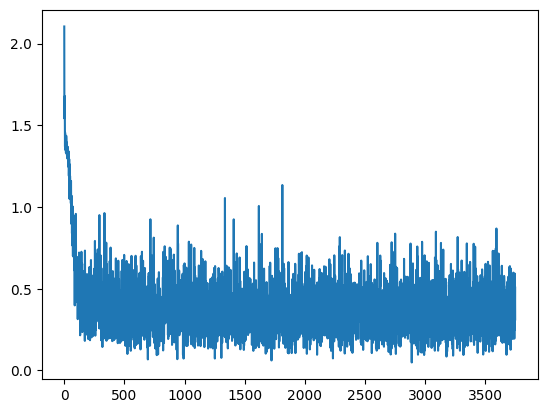

In [33]:
from matplotlib import pyplot as plt
plt.plot(batch_losses)

### 16.5.9 Evaluation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [34]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [35]:
model.eval()

for batch in dataloaders['test']:
    labels, sentences = batch['topic'], batch['news']
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    pred_class = predictions.argmax(dim=1).tolist()
    labels = labels.tolist()

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [36]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.92163543, 0.94253463, 0.85041551, 0.80623501])},
 {'recall': array([0.85421053, 0.96684211, 0.80789474, 0.88473684])},
 {'accuracy': 0.878421052631579})

### 16.5.10 Visualizing Attention

In [37]:
batch = next(iter(dataloaders['train']))
labels, sentences = batch['topic'], batch['news']

model.eval()
out = model(sentences)
scores = out['alphas']
scores.shape

torch.Size([32, 2, 59])

In [38]:
top_idxs = scores[:, :, 1:].argmax(dim=2).tolist()
top_idxs[:3]

[[8, 0], [5, 10], [1, 3]]

In [39]:
import pandas as pd

class_labels = ['world', 'sports', 'business', 'sci/tech']

results = [(class_labels[label], class_labels[prediction], tokens[idxs[0]], tokens[idxs[1]], description)
 for tokens, idxs, label, prediction, description in
 zip([tokenizer(s) for s in sentences], top_idxs, labels.tolist(), out['logits'].argmax(dim=1).tolist(), sentences)]

pd.DataFrame(results, columns=['Label', 'Prediction', 'Head #1', 'Head #2', 'News'])

,Label,Prediction,Head #1,Head #2,News
0,world,world,security,car,A car bomb explodes near the convoy of a Pales...
1,world,world,leader,file,The nephew of late Palestinian leader says Yas...
2,sports,sports,atlanta,starter,HOUSTON -- Atlanta Braves starter John Thomson...
3,sports,sports,olympic,australia,ATHENS: The Netherlands and Australia flew thr...
4,sports,sports,sports,corey,"Cromwell, CT (Sports Network) - Corey Pavin ho..."
5,sports,sports,trainer,bonds,Published reports say Barry Bonds has testifie...
6,sci/tech,sci/tech,security,panda,"The Zafi.D worm, which disguises itself as an ..."
7,world,world,abuja,africans,ABUJA -- The US declaration that Sudanese gove...
8,business,business,yusgiantoro,quarter,When asked if OPEC will discuss a possible cut...
9,sports,sports,patriots,ravens,The Ravens are focusing on the positives follo...


## 16.6 Contextual Embeddings

In [40]:
sentences = ("The core of the planet is becoming unstable.",
             "The shift in the company's core business markets had impacted their quartely results.")

In [41]:
model.eval()
out = model(sentences)
out['logits'].argmax(dim=1).tolist()

[3, 2]

In [42]:
idx0 = tokenizer(sentences[0]).index('core') + 1  # because [CLS] is 0th index
idx1 = tokenizer(sentences[1]).index('core') + 1  # because [CLS] is 0th index
idx0, idx1

(2, 6)

In [43]:
(out['embeddings'][0][idx0] == out['embeddings'][1][idx1]).all()

tensor(True, device='cuda:0')

In [44]:
out['hidden_states'][0][idx0], out['hidden_states'][1][idx1]

(tensor([-0.4593, -0.2131,  1.3669,  0.0290,  1.6493,  0.4984,  0.4805, -2.0488,
         -0.2729,  0.5454,  0.7919, -0.8594, -0.5697,  0.5280, -1.4297,  0.8409,
          0.0484,  1.1271,  0.8973, -0.7962,  0.1833, -0.5424, -0.1523, -0.0971,
         -0.6673, -0.6738, -0.7235,  0.1331,  0.2443,  0.5276,  4.9919, -0.1255,
         -0.1249, -0.9909, -0.2511,  0.1285, -1.1370, -0.1002, -0.3800, -0.5061,
         -0.3048, -1.6161, -0.8353,  0.4149,  0.1417,  0.7580,  0.4196,  0.6252,
         -0.7951, -0.1752], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([-0.8562,  0.2272,  0.9648, -0.0754,  1.4574,  0.0850,  0.5160, -2.3434,
         -0.2297,  0.4261,  0.9347, -0.9266, -0.5161,  0.6229, -1.2621,  0.7995,
         -0.0141,  1.1231,  0.8522, -0.8797,  0.3276, -0.4672, -0.1891,  0.0404,
         -0.5723, -0.7252, -0.5869,  0.0492,  0.2418,  0.6282,  4.9830, -0.1025,
         -0.0147, -0.9030, -0.2359,  0.0562, -1.0996, -0.1254, -0.3494, -0.5806,
         -0.1656, -1.6666, -0.8488, 

### 16.6.1 Sentence Embeddings

In [45]:
sentence_embeddings = out['hidden_states'][:, 0]
sentence_embeddings

tensor([[-1.3844e-01, -2.5547e-01, -1.5871e+00,  8.1905e-01, -3.5376e-01,
         -8.4699e-01, -1.2360e-01, -1.7131e-01,  7.4064e-02,  6.9637e-01,
          5.2877e-01,  1.3949e-01,  1.1430e+00, -1.0243e+00, -1.8774e+00,
          1.1917e+00,  5.3214e-01, -8.2118e-01,  6.7917e-01,  2.0933e-01,
         -1.4529e+00,  6.9079e-01, -4.9068e-01, -3.5531e-01, -2.8781e-01,
          2.5778e+00, -1.6383e+00, -5.5395e-02, -1.2500e+00, -3.6284e-01,
          7.2773e-01,  1.1527e+00,  4.5319e-01, -5.7570e-01,  1.0962e+00,
          1.2467e+00, -4.8579e-01,  2.1852e+00, -6.5953e-01,  1.7694e+00,
         -1.6112e+00,  7.1793e-01,  1.2248e-01, -3.6049e-01, -1.4951e+00,
          2.1883e+00, -1.0184e+00, -8.8738e-01,  7.9824e-01, -4.7387e-01],
        [-1.7320e+00,  4.5201e-01, -1.3106e+00,  1.4043e+00, -1.1932e+00,
         -7.1035e-01, -6.6246e-01, -1.7792e-01, -1.3805e+00,  1.8422e+00,
          4.1065e-01, -1.3086e-03,  4.4037e-01,  3.8317e-01, -1.0606e+00,
          4.0850e-01, -1.1943e+00, -7

### 16.6.3 Zero-Shot Text Classification Revisited

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [46]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sentences = ['world', 'sports', 'business', 'science and technology']
labels_emb = model.encode(sentences, convert_to_tensor=True)
labels_emb.shape

/home/dvgodoy/anaconda3/envs/pyt20/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/dvgodoy/anaconda3/envs/pyt20/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([4, 384])

In [47]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [48]:
cos = nn.CosineSimilarity(dim=-1)

for i, batch in enumerate(dataloaders['test']):
    labels, sentences = batch['topic'], batch['news']

    embeddings = model.encode(sentences, convert_to_tensor=True)

    distances = cos(embeddings.unsqueeze(1), labels_emb)

    pred_class = distances.argmax(dim=1)

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [49]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.6580743 , 0.75671982, 0.55060571, 0.57694826])},
 {'recall': array([0.45684211, 0.87421053, 0.74157895, 0.46368421])},
 {'accuracy': 0.6340789473684211})